In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
data = pd.read_csv('Wave_Current_ Speeds_TimeSeries(8.5m).csv', index_col=['DateTime'], parse_dates=['DateTime'])


In [4]:
X = data[['Wave Speed']].values  # Input: Wave Speed
y = data['Current Speed'].values  # Output: Current Speed


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Convert the NumPy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()


In [7]:
X_train = X_train.requires_grad_()


In [8]:
class CurrentSpeedPINN(torch.nn.Module):
    def __init__(self):
        super(CurrentSpeedPINN, self).__init__()
        self.dense1 = torch.nn.Linear(1, 32)  # First hidden layer with 32 neurons
        self.dense2 = torch.nn.Linear(32, 32)  # Second hidden layer with 32 neurons
        self.output_layer = torch.nn.Linear(32, 1)  # Output layer with one neuron for predicting Current Speed

    def forward(self, inputs):
        x = self.dense1(inputs)  # Pass input through the first hidden layer
        x = self.dense2(x)  # Pass through the second hidden layer
        output = self.output_layer(x)  # Output prediction
        return output

In [9]:
def physics_loss(model, X):
    predictions = model(X)
    u_pred = predictions[:, 0]
    v_pred = predictions[:, 0]  # Both u_pred and v_pred have the same value.

    # Physics-based equations
    g = 9.81
    f = 1.0e-4
    h = 1.5
    u = u_pred  # Define u based on predictions
    v = v_pred  # Define v based on predictions


# Compute the spatial derivatives of u and v
    u_x = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    v_x = torch.autograd.grad(v, X, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_y = torch.autograd.grad(v, X, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]


    h_x = 1.5  # Define h_x based on data or calculations
    h_y = 1.5  # Define h_y based on data or calculations

    physics_equations = [
        -u * u_x - v * u_y - f * u + g * h_x,
        -u * v_x - v * v_y + f * v + g * h_y
    ]


    # Compute the data loss
    data_loss = torch.mean(torch.abs(predictions.detach() - y))


# Compute the physics loss
    physics_equations = torch.stack(physics_equations)
    physics_loss_value = torch.mean(torch.abs(physics_equations))



    # Compute the total loss
    total_loss = data_loss + physics_loss_value
    
    total_loss = torch.mean(torch.abs(total_loss))
    
    return physics_loss_value, data_loss, total_loss

In [10]:
# Define training hyperparameters
learning_rate = 0.009  # Learning rate for optimization
epochs = 10000  # Number of training epochs

model = CurrentSpeedPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
# Training Loop
losses = {'physics_loss': [], 'data_loss': [], 'total_loss': []}

for epoch in range(epochs):
    optimizer.zero_grad()
    physics_loss_value, data_loss, total_loss = physics_loss(model, X_train)
    total_loss.backward()
    optimizer.step()
    
    # Append losses to the dictionary for analysis
    losses['physics_loss'].append(physics_loss_value.item())
    losses['data_loss'].append(data_loss.item())
    losses['total_loss'].append(total_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}] - Physics Loss: {physics_loss_value.item()}, Data Loss: {data_loss.item()}, Total Loss: {total_loss.item()}")


Epoch [0/10000] - Physics Loss: 14.718162536621094, Data Loss: 0.15163036479579, Total Loss: 14.869792901416885
Epoch [100/10000] - Physics Loss: 0.4963523745536804, Data Loss: 7.177422068388708, Total Loss: 7.673774442942388
Epoch [200/10000] - Physics Loss: 0.7901409268379211, Data Loss: 7.93539880864043, Total Loss: 8.725539735478351
Epoch [300/10000] - Physics Loss: 0.295193612575531, Data Loss: 8.0072290558556, Total Loss: 8.30242266843113
Epoch [400/10000] - Physics Loss: 0.9190394282341003, Data Loss: 7.650084454101847, Total Loss: 8.569123882335948
Epoch [500/10000] - Physics Loss: 0.2593023180961609, Data Loss: 8.636488687174467, Total Loss: 8.895791005270627
Epoch [600/10000] - Physics Loss: 0.24128100275993347, Data Loss: 8.858483573032965, Total Loss: 9.099764575792898
Epoch [700/10000] - Physics Loss: 0.2402370125055313, Data Loss: 8.892793879075146, Total Loss: 9.133030891580677
Epoch [800/10000] - Physics Loss: 0.2481188178062439, Data Loss: 8.730678178277984, Total Loss

Epoch [7100/10000] - Physics Loss: 0.13815639913082123, Data Loss: 12.123199461072806, Total Loss: 12.261355860203627
Epoch [7200/10000] - Physics Loss: 0.6253796815872192, Data Loss: 10.85965525247422, Total Loss: 11.485034934061439
Epoch [7300/10000] - Physics Loss: 0.15732842683792114, Data Loss: 11.341697884391504, Total Loss: 11.499026311229425
Epoch [7400/10000] - Physics Loss: 0.2753629684448242, Data Loss: 12.767717247840764, Total Loss: 13.043080216285588
Epoch [7500/10000] - Physics Loss: 0.13133227825164795, Data Loss: 12.079997045551368, Total Loss: 12.211329323803016
Epoch [7600/10000] - Physics Loss: 0.2963687777519226, Data Loss: 12.481285627852804, Total Loss: 12.777654405604727
Epoch [7700/10000] - Physics Loss: 0.1532464325428009, Data Loss: 11.99507460839271, Total Loss: 12.14832104093551
Epoch [7800/10000] - Physics Loss: 0.33920031785964966, Data Loss: 11.054574799222518, Total Loss: 11.393775117082168
Epoch [7900/10000] - Physics Loss: 0.1771618276834488, Data Los

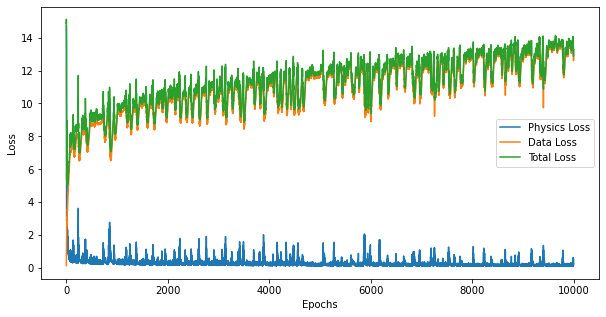

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses['physics_loss'], label='Physics Loss')
plt.plot(range(epochs), losses['data_loss'], label='Data Loss')
plt.plot(range(epochs), losses['total_loss'], label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# After training, evaluate the model on the test data
with torch.no_grad():
    y_pred = model(X_test)

    # Convert tensors to NumPy arrays for plotting
    y_test_numpy = y_test.cpu().numpy()
    y_pred_numpy = y_pred.cpu().numpy()

    mse = torch.mean(torch.square(y_test - y_pred)).item()
    mae = torch.mean(torch.abs(y_test - y_pred)).item()

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

    

Mean Squared Error: 160.708251953125
Mean Absolute Error: 12.676233291625977
